## Advanced Topics in Computional Intelligence
### Advantage Actor Critic Implementation
*Natalia Jakubiak*

This work is structured as 2 isolated jupyter notebooks: 
* a2c_cartpole_report.ipynb - contains the description of an implementation and solution for OpenAI problem "CartPole-V1"
* a2c_lunarlander.ipynb - contains solution for "LunarLander-v2" problem

### Introduction 


The goal of this exercise is to implement an Advantage Actor Critic algorithm for solving two problems from OpenAI gym: the classic CartPole problem and more complex LunarLander problem.

### Software


The implementation of this assignment was performed on Jupyter notebook, using Python 3.7.
The included packages that were exploited are the following:
* PyTorch 1.8.1
* Gym 0.17.3
* Matplotlib: Python library used to plot
* Numpy, Collections: Python library used to do mathematical operations

The first attempt to implement the A2C algorithm was made using Tensorflow. However, the training time was very long, so I decided to write it again using PyTorch so that I could do more experiments with different hyperparameters.



In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import matplotlib.pyplot as plt
import collections

### Advantage Actor Critic Algorithm

The actor critic algorithm consists of two networks (the actor and the critic) working together to solve a particular problem. At a high level, the Advantage Function calculates the agent’s TD Error or Prediction Error. The actor network chooses an action at each time step and the critic network evaluates the quality or the Q-value of a given input state. As the critic network learns which states are better or worse, the actor uses this information to teach the agent to seek out good states and avoid bad states.

### Cartpole problem

*In the CartPole-v0 environment, a pole is attached to a cart moving along a frictionless track. The pole starts upright and the goal of the agent is to prevent it from falling over by applying a force of -1 or +1 to the cart. A reward of +1 is given for every time step the pole remains upright. An episode ends when (1) the pole is more than 15 degrees from vertical or (2) the cart moves more than 2.4 units from the center.*

**The problem is considered "solved" when the average total reward for the episode reaches 200 over 100 consecutive trials.**

For Cartpole-v0, there are four values representing the state: cart position, cart-velocity, pole angle and pole velocity respectively. The agent can take two actions to push the cart left (0) and right (1) respectively.

#### Defining the Actor Network

The actor network maps each state to a corresponding action. It's weights are updated after every time step.

The simple implementation of the policy network consisting of 2 densely connected layers is sufficient for CartPole problem. The network uses the Softmax activation function, because it allows us to interpret the policy output as a probability distribution, which is needed for the loss function. 

In [ ]:
class Actor(nn.Module):
    '''
    Actor: Input of states and outputs the probability of an action (softmax)
    '''
    def __init__(self, n_action, space_dim, hidden_dim):
        super(Actor, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(space_dim, hidden_dim),
            nn.ReLU(True),
        )
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, n_action),
            nn.Softmax(dim=-1),
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        policy = self.actor(features)
        return policy
    

#### Defining the Critic Network
The critic network maps each state to its corresponding Q-value - this network has a single output, which estimates the future reward one can gain from a certain state. (It also consists 2 dense layers and ReLU activation function between them).

In [ ]:
class Critic(nn.Module):
    '''
    Critic: Input is also state but the output is also state(linear)
    '''
    def __init__(self, space_dim, hidden_dim):
        super(Critic, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(space_dim, hidden_dim),
            nn.ReLU(True),
        )
        self.critic = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        est_reward = self.critic(features)
        return est_reward

#### The Actor-Critic loss

For both the policy and the value function separate loss functions are defined.

The value function (critic) is used to generate targets:

$$
y_t = r_t + \gamma V_\phi(s_{t+1})
$$


The loss function for the value function is nothing more than the squared difference between the estimated value and the actual reward given a certain state.
$$
CriticLoss = \sum_{t=0}^T (y_t -  V_\phi (s_t))^2
$$


The critic basically tries to minimize the mean-squared error, so the *MSELoss* function is used.


In [ ]:
# Critic loss function
mse_loss = nn.MSELoss()

The policy loss has the same form as in the plicy gradient methods implementation. The only difference is that it uses the advantages instead of returns as a reinforcing signal. 

$$
ActorLoss = - \sum_{t=0}^T  \log \pi_\theta(s_t \mid a_t) A^{\pi_\theta}(s_t, a_t) 
$$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

In [ ]:
# Actor loss function (policy gradient method loss)
# Equivalent of tensorflow equation: loss = - tf.reduce mean(tf.log(prob outputs) * reward) [Source: ATCI presentation, Policy gradient methods, slide 34 ]
class PGLoss(nn.Module):
    def __init__(self):
        super(PGLoss, self).__init__()
    
    def forward(self, action_prob, reward):
        loss = -torch.mean(torch.log(action_prob+1e-6)*reward)
        return loss
pg_loss = PGLoss()

The Advantage is equal to the TD Error. To calculate it, first the TD Target value needs to be calculated. In the implementation below following equations are used:
1. The TD Target if not the last step of episode
$$Q^{\pi_\theta}(s_t, a_t) =  \mathbb{E} \left[r_t + \gamma V_\phi(s_{t+1})\right]$$
2. The last step's TD Target
$$Q^{\pi_\theta}(s_t, a_t) = r_t$$

TD Target is the predicted value of all future rewards from the current state S. The function V(st+1) represents the Critic Network calculating the value of the next state St+1.

Advantage is defined as the TD Target minus the value of the current state S - V(st).
$$
A^{\pi_\theta}(s_t, a_t) = Q^{\pi_\theta}(s_t, a_t) - V^{\pi_\theta}(s_t)
$$

The Advantage function says if a state is better or worse than expected. If an action is better than expected (the advantage is greater than 0), we want to encourage the actor to take more of that action. If an action is worse than expected (the advantage is less than 0), we want to encourage the actor to take the opposite of that action. If an action performs exactly as expected (the advantage equals 0), the actor doesn’t learn anything from that action.


#### Auxiliar functions

In [ ]:
# Return a new tensor with a dimension of size one inserted at the specified position
def to_tensor(x, dtype=None):
    return torch.tensor(x, dtype=dtype).unsqueeze(0)

In [ ]:
# Using the output of policy network, pick action stochastically
def get_action(policy):
    return np.random.choice(len(policy), 1, p=policy)[0]

#### Environment initialization

In [ ]:
# Load environment
env = gym.make('CartPole-v1')

In [ ]:
# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
# number of hidden units for networks architecture
hidden_dim = 32

In [ ]:
# Set seed for experiment reproducibility
SEED = 42
env.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# Parameters for learning
discounted_factor = 0.99 
actor_lr = 0.001
critic_lr = 0.005
EPISODES = 1000

In [ ]:
# Create actor and critic networks
actor = Actor(action_size, state_size, hidden_dim)
critic = Critic(state_size, hidden_dim)

# Add Adam Optimizer training for both the actor and critic functions, each with their own learning rate
actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)
critic_optim = torch.optim.Adam(critic.parameters(), lr=critic_lr)

#### Actor-Critic Training Loop

Training is executed by running the training step until either the success criterion or maximum number of episodes is reached.

A running record of episode rewards is kept in a queue (*scores_dq*). Once 100 trials are reached, the oldest reward is removed at the left (tail) end of the queue and the newest one is added at the head (right). A running sum of the rewards is also maintained for computational efficiency.

To train the agent, model follows these steps (for each episode):
1. Estimate action with policy network taking into acount current state.
2. Interact with environment to collect training data per episode.
3. Compute expected return at each time step.
4. Calculated TD error.
5. Compute the loss for the actor-critic model.
6. Update networks parameters.
7. Repeat 1-6 until the episode is finished (done = True).

Training data is collected for each time step. The next action is sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.
Then, the model's forward pass is run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

At the beginning of the learning process, the critic will likely make large errors causing the calculated TD error to be quite incorrect. Because the algorithm starts out with the critic having no knowledge of the environment, the actor similarly can’t learn much from the critic. As the critic starts to make more and more accurate predictions, the calculated TD error (Advantage) becomes more accurate. The actor is able to learn from the increasingly accurate TD error to decide if a move was good or bad.



In [ ]:
# Scores list
reward_lst = []
# Average scores list
avg_reward_lst = []
# Deque to store the long-term-reward of the last 100 experiments 
scores_dq = collections.deque(maxlen=100)

for e in range(EPISODES):
    done = False
    score = 0
    # reset() returns a rondom initial state
    state = to_tensor(env.reset(), dtype=torch.float)
    while not done:
        # clear gradient
        actor_optim.zero_grad()
        critic_optim.zero_grad()
        
        # estimate action with policy network by sampling action from the prob distribution instead of using argmax
        policy = actor(state)
        action = get_action(policy.detach().numpy()[0])
        
        # take the action and observe results - interact with the environment
        next_state, reward, done, info = env.step(action)
        
        next_state = to_tensor(next_state, dtype=torch.float)
        advantages = torch.zeros_like(policy)
        
        # get value for this state
        value = critic(state)[0]
        # get value for the next state
        next_value = critic(next_state)[0]

        # update the advantages and TD target
        if done:
            # if an action make the episode end, then gives penalty of -100
            # reward = reward if not done or score == 499 else -100
            t_reward = to_tensor([-100], dtype=torch.float) if score < 499 else to_tensor([reward], dtype=torch.float)
            advantages[0, action] = t_reward - value
            target = t_reward
        else:
            t_reward = to_tensor([reward], dtype=torch.float)
            advantages[0, action] = t_reward + discounted_factor*next_value - value
            target = t_reward + discounted_factor*next_value
        
        state = next_state

        # update actor critic
        actor_loss = pg_loss(policy, advantages.detach())
        critic_loss = mse_loss(value, target.detach())
        # loss function is a combination of actor and critic losses for training
        loss = actor_loss + critic_loss
        loss.backward()
        actor_optim.step()
        critic_optim.step()
        
        if not done:
            score += reward

    scores_dq.append(score)
    reward_lst.append(score)
    mean_score = np.mean(scores_dq)
    avg_reward_lst.append(mean_score)
    if mean_score >= 250 and e >= 100:
        print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))    
        break
    print('Episodes: {}, Average Reward: {:.3f}, Reward: {}'.format(e, mean_score, score))



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episodes: 0, Average Reward: 95.000, Reward: 95.0
Episodes: 1, Average Reward: 79.500, Reward: 64.0
Episodes: 2, Average Reward: 60.667, Reward: 23.0
Episodes: 3, Average Reward: 48.250, Reward: 11.0
Episodes: 4, Average Reward: 40.600, Reward: 10.0
Episodes: 5, Average Reward: 37.333, Reward: 21.0
Episodes: 6, Average Reward: 34.000, Reward: 14.0
Episodes: 7, Average Reward: 31.750, Reward: 16.0
Episodes: 8, Average Reward: 29.444, Reward: 11.0
Episodes: 9, Average Reward: 27.600, Reward: 11.0
Episodes: 10, Average Reward: 26.818, Reward: 19.0
Episodes: 11, Average Reward: 28.750, Reward: 50.0
Episodes: 12, Average Reward: 27.615, Reward: 14.0
Episodes: 13, Average Reward: 27.286, Reward: 23.0
Episodes: 14, Average Reward: 26.200, Reward: 11.0
Episodes: 15, Average Reward: 25.688, Reward: 18.0
Episodes: 16, Average Reward: 27.941, Reward: 64.0
Episodes: 17, Average Reward: 27.444, Reward: 19.0
Episodes: 18, Average Reward: 27.053, Reward: 20.0
Episodes: 19, Average Reward: 26.450, Rew

### Results

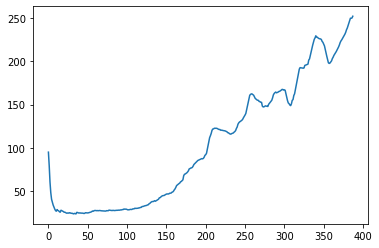

In [ ]:
plt.plot(avg_reward_lst)
plt.show()

Above plot is for the average score of 100 consecutive trials for 387 runs.
CartPole-v1 states the problem is solved by getting an average reward of 200 over 100 consecutive trials. I set the treshold = 250. As can be seen model is getting an average score above 250 after 387 runs, but first, it takes about 200 runs to get an average score above even 100.

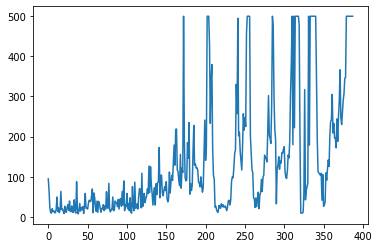

In [ ]:
plt.plot(reward_lst)
plt.show()

Above plot shows exact value of the rewards for 387 runs. 
Can be noticed that the agent still gets erratic behaviour instead of a general solution. That is because a stochastic approach is used for the implementation (get_action function uses random choice with probability set as the policy) - the policy is not hardcoded, so there will always be a time where an agent will try to do a weird move. This is in line with the exploration vs. exploitation method.

In conclusion, can be observed that A2C is a powerful algorithms that can efficiently solve problems such as CartPole. However, selecting the proper parameters and networks' architectures significantly affects its performance. When the architecture of the network was too complex or the learning rate was too high, the agent did not learn and the behaviour was random. 